# Ejemplos de RNN, GRU, LSTM, Modelos secuenciales bidireccionales y profundos.

Este código tiene como finalidad evaluar los diferentes tipos de arqitecturas de modelos secuenciales para resolver un problema de series de tiempo relacionada con la predicción Sunspot (manchas negras en el sol). La base de datos está disponible en https://www.kaggle.com/datasets/robervalt/sunspots

## Etapa 1: Se carga la base de datos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [ ]:
# Se carga el archivo csv
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
df = read_csv(url)
df

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
...,...,...
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3


In [ ]:
# Se tiene en cuenta únicamente la información de los Sunspots
data =  np.array(df.Sunspots.astype('float32'))
data

array([58. , 62.6, 70. , ..., 55.8, 33.3, 33.4], dtype=float32)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Se normalizan los datos 
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
n = len(data)

In [ ]:
# Punto temporal para dividir entre train y test
percent = 0.8
split = int(n*percent)
train_data = data[:split]
test_data = data[split:]

## Etapa 2: Condiguración de la base de datos para entrenar los modelos

La variable train_data tiene los datos de los sunspots, ahora tenemos que configurar el xtrain y el ytrain para configurar el problema de forecasting. La idea es la siguiente, con base en los valores pasados de sunspots se predice el próximo valor. Por ejemplo supongamos que se tienen 8 valores en la variable train_data

$$train\_data = [0, 10, 20, 30, 40, 50, 60, 70]$$.

Además, supongamos que se utilizará una ventana de 2 muestras, esto quiere decir que la predicción de la variable se realizará a partir de dos muestras anteriores. De esta forma el xtrain y ytrain se forman así:

$$xtrain = \begin{bmatrix}0 & 10\\ 20& 30\\40&50\end{bmatrix}, \quad ytrain = \begin{bmatrix}20\\40\\60\end{bmatrix}$$

In [ ]:
# Esta función realiza la generación de xtrain y ytrain a partir del proceso 
# explicado anteriormente.
def get_XY(dat, time_steps):
    # Se generan los índices para generar las salidas "y"
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Ahora se generan las entradas $x$ 
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 12 # Se define a partir de cuántas muestras se hará la predicción
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

## Etapa 3: Construir un modelo secuencial a partir de una RNN

In [ ]:
input_shape = (time_steps,1) # Con esto se define cuántas unidades secuenciales
                             # (RNN) tiene la red 
hidden_units = 3 # Recordemos que cada unidad secuencial está compuesta por una 
                  # red densa, esa capa densa tendrá hidden_units neuronas.
dense_units  = 1 # una única salida

In [ ]:
# Se crea el modelo secuencial
model = Sequential()
model.add(SimpleRNN(hidden_units, input_shape=input_shape, 
                    activation='relu'))
model.add(Dense(units=dense_units))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 1s - loss: 0.0304 - 1s/epoch - 6ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0192 - 264ms/epoch - 1ms/step
Epoch 3/20
187/187 - 0s - loss: 0.0179 - 264ms/epoch - 1ms/step
Epoch 4/20
187/187 - 0s - loss: 0.0169 - 259ms/epoch - 1ms/step
Epoch 5/20
187/187 - 0s - loss: 0.0157 - 266ms/epoch - 1ms/step
Epoch 6/20
187/187 - 0s - loss: 0.0143 - 279ms/epoch - 1ms/step
Epoch 7/20
187/187 - 0s - loss: 0.0129 - 263ms/epoch - 1ms/step
Epoch 8/20
187/187 - 0s - loss: 0.0112 - 271ms/epoch - 1ms/step
Epoch 9/20
187/187 - 0s - loss: 0.0095 - 276ms/epoch - 1ms/step
Epoch 10/20
187/187 - 0s - loss: 0.0078 - 270ms/epoch - 1ms/step
Epoch 11/20
187/187 - 0s - loss: 0.0063 - 265ms/epoch - 1ms/step
Epoch 12/20
187/187 - 0s - loss: 0.0050 - 265ms/epoch - 1ms/step
Epoch 13/20
187/187 - 0s - loss: 0.0042 - 265ms/epoch - 1ms/step
Epoch 14/20
187/187 - 0s - loss: 0.0037 - 271ms/epoch - 1ms/step
Epoch 15/20
187/187 - 0s - loss: 0.0035 - 257ms/epoch - 1ms/step
Epoch 16/20
187/187 - 0s - loss: 0.00

In [ ]:
# Función para calcular el error de la predicción
def print_error(trainY, testY, train_predict, test_predict):    
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# Realizar las predicciones
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 3ms/step
Train RMSE: 0.058 RMSE
Test RMSE: 0.075 RMSE


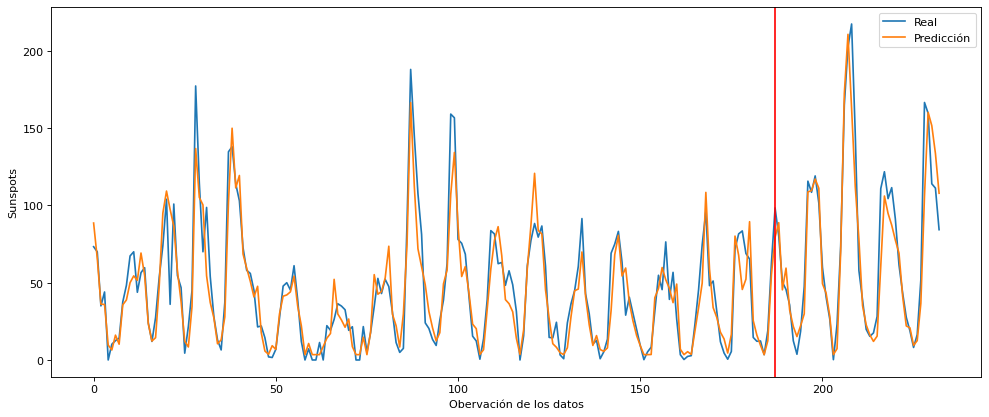

In [ ]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    actual = scaler.inverse_transform(actual.reshape(-1, 1)) # transformación inversa
    predictions = np.append(train_predict, test_predict)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Real', 'Predicción'])
    plt.xlabel('Obervación de los datos')
    plt.ylabel('Sunspots')
plot_result(trainY, testY, train_predict, test_predict)

## Etapa 4: Modelo secuencial con GRU

In [ ]:
hidden_units = 16 # Recordemos que cada unidad secuencial está compuesta por una 
                  # red densa, esa capa densa tendrá hidden_units neuronas.
dense_units  = 1 # una única salida

# Se crea el modelo secuencial
model = Sequential()
model.add(GRU(hidden_units, input_shape=input_shape, 
                    activation='relu'))
model.add(Dense(units=dense_units))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                912       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 1s - loss: 0.0131 - 1s/epoch - 7ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0062 - 458ms/epoch - 2ms/step
Epoch 3/20
187/187 - 1s - loss: 0.0042 - 519ms/epoch - 3ms/step
Epoch 4/20
187/187 - 0s - loss: 0.0035 - 367ms/epoch - 2ms/step
Epoch 5/20
187/187 - 0s - loss: 0.0035 - 381ms/epoch - 2ms/step
Epoch 6/20
187/187 - 0s - loss: 0.0035 - 388ms/epoch - 2ms/step
Epoch 7/20
187/187 - 0s - loss: 0.0038 - 353ms/epoch - 2ms/step
Epoch 8/20
187/187 - 0s - loss: 0.0036 - 374ms/epoch - 2ms/step
Epoch 9/20
187/187 - 0s - loss: 0.0036 - 344ms/epoch - 2ms/step
Epoch 10/20
187/187 - 0s - loss: 0.0036 - 342ms/epoch - 2ms/step
Epoch 11/20
187/187 - 0s - loss: 0.0035 - 337ms/epoch - 2ms/step
Epoch 12/20
187/187 - 0s - loss: 0.0036 - 341ms/epoch - 2ms/step
Epoch 13/20
187/187 - 0s - loss: 0.0036 - 363ms/epoch - 2ms/step
Epoch 14/20
187/187 - 0s - loss: 0.0035 - 343ms/epoch - 2ms/step
Epoch 15/20
187/187 - 0s - loss: 0.0035 - 335ms/epoch - 2ms/step
Epoch 16/20
187/187 - 0s - loss: 0.00

In [ ]:
# Realizar las predicciones
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 5ms/step
Train RMSE: 0.058 RMSE
Test RMSE: 0.077 RMSE


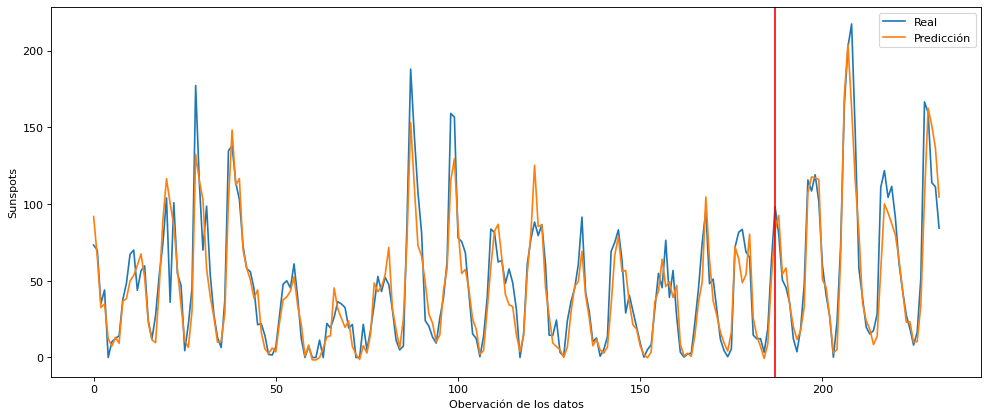

In [ ]:
plot_result(trainY, testY, train_predict, test_predict)

## Etapa 5: Modelo secuencial con LSTM

In [ ]:
hidden_units = 64 # Recordemos que cada unidad secuencial está compuesta por una 
                  # red densa, esa capa densa tendrá hidden_units neuronas.
dense_units  = 1 # una única salida

# Se crea el modelo secuencial
model = Sequential()
model.add(LSTM(hidden_units, input_shape=input_shape, 
                    activation='relu'))
model.add(Dense(units=dense_units))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 1s - loss: 0.0074 - 1s/epoch - 7ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0045 - 380ms/epoch - 2ms/step
Epoch 3/20
187/187 - 0s - loss: 0.0051 - 375ms/epoch - 2ms/step
Epoch 4/20
187/187 - 0s - loss: 0.0048 - 377ms/epoch - 2ms/step
Epoch 5/20
187/187 - 0s - loss: 0.0048 - 393ms/epoch - 2ms/step
Epoch 6/20
187/187 - 0s - loss: 0.0042 - 381ms/epoch - 2ms/step
Epoch 7/20
187/187 - 0s - loss: 0.0038 - 474ms/epoch - 3ms/step
Epoch 8/20
187/187 - 1s - loss: 0.0041 - 516ms/epoch - 3ms/step
Epoch 9/20
187/187 - 1s - loss: 0.0043 - 549ms/epoch - 3ms/step
Epoch 10/20
187/187 - 1s - loss: 0.0044 - 536ms/epoch - 3ms/step
Epoch 11/20
187/187 - 0s - loss: 0.0040 - 395ms/epoch - 2ms/step
Epoch 12/20
187/187 - 0s - loss: 0.0038 - 412ms/epoch - 2ms/step
Epoch 13/20
187/187 - 0s - loss: 0.0037 - 381ms/epoch - 2ms/step
Epoch 14/20
187/187 - 0s - loss: 0.0039 - 394ms/epoch - 2ms/step
Epoch 15/20
187/187 - 0s - loss: 0.0037 - 387ms/epoch - 2ms/step
Epoch 16/20
187/187 - 0s - loss: 0.00

In [ ]:
# Realizar las predicciones
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 6ms/step
Train RMSE: 0.057 RMSE
Test RMSE: 0.078 RMSE


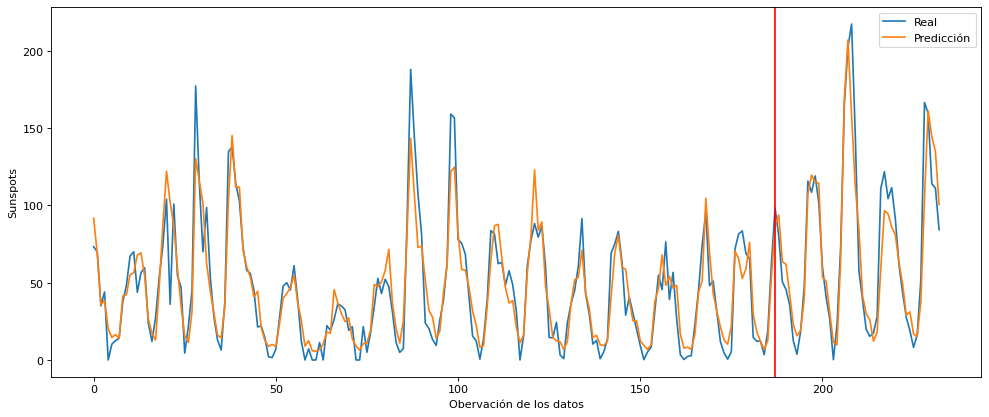

In [ ]:
plot_result(trainY, testY, train_predict, test_predict)

## Etapa 6: Modelos secuenciales bidireccionales

In [ ]:
hidden_units = 16 # Recordemos que cada unidad secuencial está compuesta por una 
                  # red densa, esa capa densa tendrá hidden_units neuronas.
dense_units  = 1 # una única salida

# Se crea el modelo secuencial
model = Sequential()
# En keras, se usa la capa Bidirectional, como argumento recibe cualquier tipo de 
# capa entre la RNN, la GRU y la LSTM
model.add(Bidirectional(GRU(hidden_units, input_shape=input_shape, 
                    activation='relu')))
model.add(Dense(units=dense_units))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 2s - loss: 0.0089 - 2s/epoch - 11ms/step
Epoch 2/20
187/187 - 1s - loss: 0.0070 - 516ms/epoch - 3ms/step
Epoch 3/20
187/187 - 1s - loss: 0.0060 - 518ms/epoch - 3ms/step
Epoch 4/20
187/187 - 1s - loss: 0.0053 - 537ms/epoch - 3ms/step
Epoch 5/20
187/187 - 1s - loss: 0.0047 - 551ms/epoch - 3ms/step
Epoch 6/20
187/187 - 1s - loss: 0.0048 - 549ms/epoch - 3ms/step
Epoch 7/20
187/187 - 1s - loss: 0.0043 - 549ms/epoch - 3ms/step
Epoch 8/20
187/187 - 1s - loss: 0.0043 - 736ms/epoch - 4ms/step
Epoch 9/20
187/187 - 1s - loss: 0.0040 - 794ms/epoch - 4ms/step
Epoch 10/20
187/187 - 1s - loss: 0.0041 - 742ms/epoch - 4ms/step
Epoch 11/20
187/187 - 1s - loss: 0.0039 - 517ms/epoch - 3ms/step
Epoch 12/20
187/187 - 1s - loss: 0.0037 - 519ms/epoch - 3ms/step
Epoch 13/20
187/187 - 1s - loss: 0.0038 - 566ms/epoch - 3ms/step
Epoch 14/20
187/187 - 1s - loss: 0.0036 - 521ms/epoch - 3ms/step
Epoch 15/20
187/187 - 1s - loss: 0.0038 - 524ms/epoch - 3ms/step
Epoch 16/20
187/187 - 1s - loss: 0.0

In [ ]:
# Realizar las predicciones
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 5ms/step
Train RMSE: 0.057 RMSE
Test RMSE: 0.076 RMSE


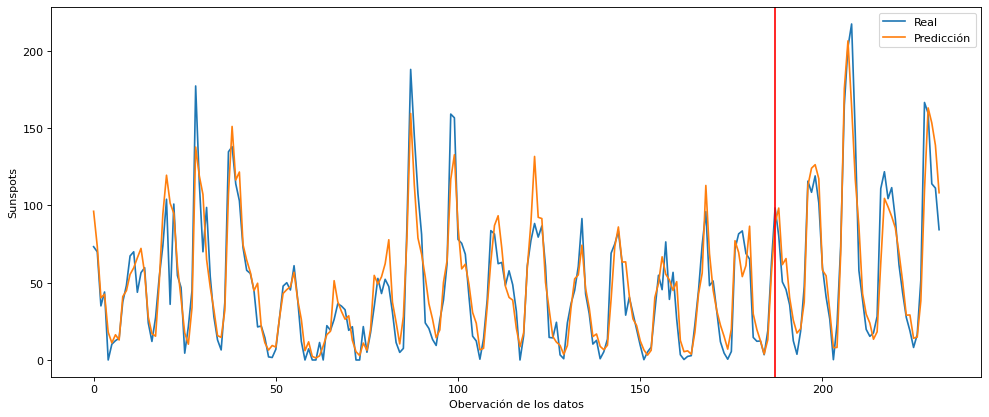

In [ ]:
plot_result(trainY, testY, train_predict, test_predict)

## Etapa 7: Modelos secuenciales profundos

In [ ]:
hidden_units = 16 # Recordemos que cada unidad secuencial está compuesta por una 
                  # red densa, esa capa densa tendrá hidden_units neuronas.
dense_units  = 1 # una única salida

# Se crea el modelo secuencial
model = Sequential()
# En keras, se usa la capa Bidirectional, como argumento recibe cualquier tipo de 
# capa entre la RNN, la GRU y la LSTM
model.add(LSTM(hidden_units, input_shape=input_shape, return_sequences=True, 
               # Para las capas ocultas se debe fijar return_sequences=True
                    activation='relu'))
model.add(LSTM(hidden_units, input_shape=input_shape, 
                    activation='relu'))
model.add(Dense(units=dense_units))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 3s - loss: 0.0122 - 3s/epoch - 15ms/step
Epoch 2/20
187/187 - 1s - loss: 0.0063 - 603ms/epoch - 3ms/step
Epoch 3/20
187/187 - 1s - loss: 0.0058 - 575ms/epoch - 3ms/step
Epoch 4/20
187/187 - 1s - loss: 0.0057 - 602ms/epoch - 3ms/step
Epoch 5/20
187/187 - 1s - loss: 0.0056 - 604ms/epoch - 3ms/step
Epoch 6/20
187/187 - 1s - loss: 0.0059 - 578ms/epoch - 3ms/step
Epoch 7/20
187/187 - 1s - loss: 0.0051 - 581ms/epoch - 3ms/step
Epoch 8/20
187/187 - 1s - loss: 0.0049 - 575ms/epoch - 3ms/step
Epoch 9/20
187/187 - 1s - loss: 0.0048 - 589ms/epoch - 3ms/step
Epoch 10/20
187/187 - 1s - loss: 0.0046 - 576ms/epoch - 3ms/step
Epoch 11/20
187/187 - 1s - loss: 0.0051 - 598ms/epoch - 3ms/step
Epoch 12/20
187/187 - 1s - loss: 0.0047 - 618ms/epoch - 3ms/step
Epoch 13/20
187/187 - 1s - loss: 0.0049 - 585ms/epoch - 3ms/step
Epoch 14/20
187/187 - 1s - loss: 0.0046 - 694ms/epoch - 4ms/step
Epoch 15/20
187/187 - 1s - loss: 0.0047 - 936ms/epoch - 5ms/step
Epoch 16/20
187/187 - 1s - loss: 0.0

In [ ]:
# Realizar las predicciones
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 5ms/step
Train RMSE: 0.062 RMSE
Test RMSE: 0.089 RMSE


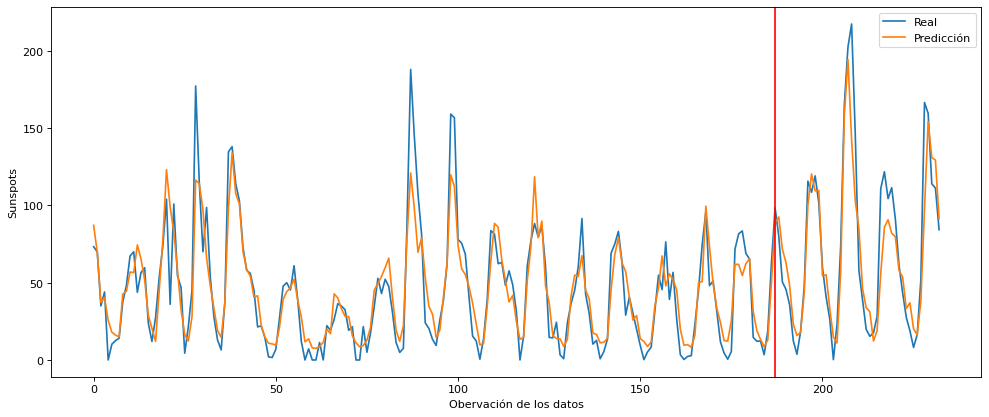

In [ ]:
plot_result(trainY, testY, train_predict, test_predict)